### Model Building, Scoring and Evaluation using LightGBM

In [1]:
# Import Libraries
from snowflake.snowpark.session import Session
import snowflake.snowpark.types as T

from lightgbm import LGBMClassifier
from snowflake.ml.modeling.metrics import *

import json
import pandas as pd
import seaborn as sns

/Users/navisha/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Create Snowpark Session
with open('creds.json') as f:
    connection_parameters = json.load(f)

session = Session.builder.configs(connection_parameters).create()
print(f"Current Database and schema: {session.get_fully_qualified_current_schema()}")
print(f"Current Warehouse: {session.get_current_warehouse()}")

Current Database and schema: "CC_DB"."PUBLIC"
Current Warehouse: "CC_WH"


### Model Building

In [51]:
train_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED_TRAIN')
test_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED_TEST')

In [4]:
# Fitting a LightGBM model using snowpark-ml
feature_cols = train_sdf.columns
feature_cols.remove('TARGET')
feature_cols.remove('ID')
target_col = 'TARGET'

In [5]:
# train the model
lgbm = LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    num_leaves=31
)

In [6]:
# Fit the model on the training data
lgbm.fit(
    train_sdf.select(*feature_cols).to_pandas(),
    train_sdf.select(target_col).to_pandas().values.ravel()
)

[LightGBM] [Info] Number of positive: 24001, number of negative: 23860
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9005
[LightGBM] [Info] Number of data points in the train set: 47861, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501473 -> initscore=0.005892
[LightGBM] [Info] Start training from score 0.005892


LGBMClassifier(metric='binary_logloss', objective='binary', random_state=42)

<Axes: >

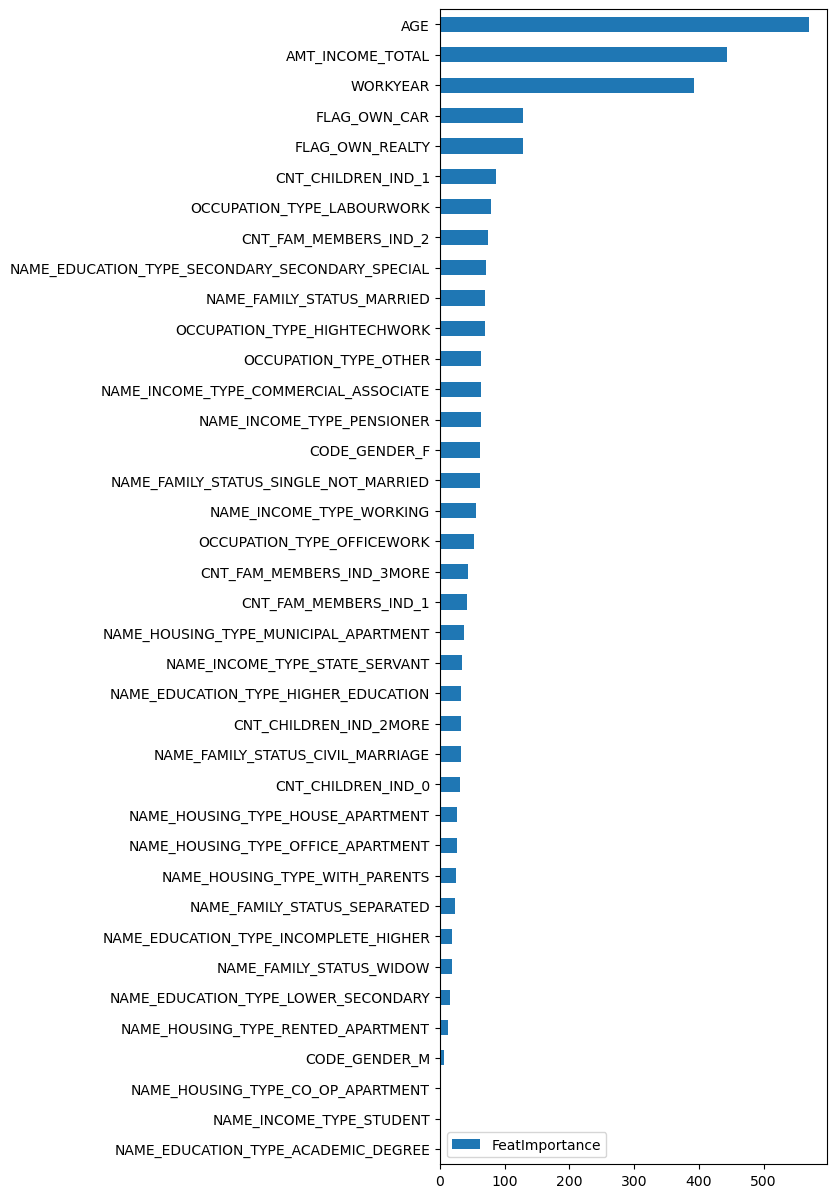

In [10]:
# Plot feature importance
feat_importance = pd.DataFrame(lgbm.feature_importances_,lgbm.feature_name_,columns=['FeatImportance'])
feat_importance.sort_values('FeatImportance').plot.barh(y='FeatImportance', figsize=(5,15))


### Model Scoring

In [52]:
# Convert Snowpark DataFrame to Pandas DataFrame
test_df = test_sdf.to_pandas()

In [53]:
score = lgbm.predict(test_df[feature_cols])

In [58]:
print(score)

[0 0 0 ... 1 1 1]


In [59]:
# Join score to test_df
test_df['PREDICTION'] = score

In [60]:
test_df

,AMT_INCOME_TOTAL,AGE,WORKYEAR,CODE_GENDER_F,CODE_GENDER_M,NAME_INCOME_TYPE_COMMERCIAL_ASSOCIATE,NAME_INCOME_TYPE_PENSIONER,NAME_INCOME_TYPE_STATE_SERVANT,NAME_INCOME_TYPE_STUDENT,NAME_INCOME_TYPE_WORKING,...,NAME_HOUSING_TYPE_HOUSE_APARTMENT,NAME_HOUSING_TYPE_MUNICIPAL_APARTMENT,NAME_HOUSING_TYPE_OFFICE_APARTMENT,NAME_HOUSING_TYPE_RENTED_APARTMENT,NAME_HOUSING_TYPE_WITH_PARENTS,FLAG_OWN_CAR,FLAG_OWN_REALTY,ID,TARGET,PREDICTION
0,0.723608,1.244158,0.193361,1.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,...,1.0,0.000000,0.0,0.000000,0.0,0.000000,1.000000,5008811,0,0
1,0.723608,0.619654,-0.734320,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,1.000000,...,1.0,0.000000,0.0,0.000000,0.0,1.000000,1.000000,5008815,0,0
2,-0.568436,0.827822,-0.579707,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,...,1.0,0.000000,0.0,0.000000,0.0,1.000000,1.000000,5008820,0,0
3,-0.568436,0.827822,-0.579707,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,...,1.0,0.000000,0.0,0.000000,0.0,1.000000,1.000000,5008822,0,0
4,-0.783777,1.660495,0.811816,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,...,1.0,0.000000,0.0,0.000000,0.0,1.000000,1.000000,5008852,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10713,-0.508725,-1.381994,-0.972093,1.000000,0.000000,0.231074,0.000000,0.000000,0.0,0.768926,...,1.0,0.000000,0.0,0.000000,0.0,1.000000,0.000000,5117923,1,1
10714,0.077586,-0.108934,0.347975,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,...,1.0,0.000000,0.0,0.000000,0.0,0.000000,1.000000,5115610,1,1
10715,-0.125225,0.175783,-0.115866,0.735453,0.264547,0.000000,0.735453,0.264547,0.0,0.000000,...,1.0,0.000000,0.0,0.000000,0.0,0.000000,0.735453,5046224,1,1
10716,0.110954,-0.208416,-0.422814,1.000000,0.000000,0.000000,0.000000,0.671580,0.0,0.328420,...,1.0,0.000000,0.0,0.000000,0.0,0.000000,0.671580,5090433,1,1


In [61]:
# Convert the test DataFrame back to a Snowpark DataFrame
test_sdf_with_predictions = session.create_dataframe(
    test_df,
    schema=None
)

In [62]:
# Save the predictions back to Snowflake
test_sdf_with_predictions.write.save_as_table(table_name="CREDIT_RISK_TEST_SCORED_LGBM", mode='overwrite')

In [63]:
test_sdf_with_predictions.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [64]:
scored_sdf = session.table("CREDIT_RISK_TEST_SCORED_LGBM")

### Evaluation

Acccuracy: 0.988431
Precision: 0.989854153455929


DataFrame.flatten() is deprecated since 0.7.0. Use `DataFrame.join_table_function()` instead.


Recall: 0.9840302584576591
F1: 0.9869336143308747


<Axes: >

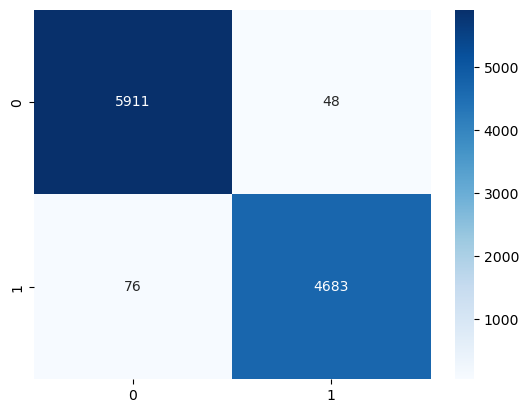

In [65]:
print('Acccuracy:', accuracy_score(df=scored_sdf, y_true_col_names='TARGET', y_pred_col_names='PREDICTION'))
print('Precision:', precision_score(df=scored_sdf, y_true_col_names='TARGET', y_pred_col_names='PREDICTION'))
print('Recall:', recall_score(df=scored_sdf, y_true_col_names='TARGET', y_pred_col_names='PREDICTION'))
print('F1:', f1_score(df=scored_sdf, y_true_col_names='TARGET', y_pred_col_names='PREDICTION'))

# Obtaining and plotting a simple confusion matrix
cf_matrix = confusion_matrix(df=scored_sdf, y_true_col_name='TARGET', y_pred_col_name='PREDICTION')

sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Blues')

In [66]:
session.close()  # Close the Snowpark session

Since we are predicting Credit Card Approval, we are more focused on identifying high risk customers. 
In this case, we need to focus on both False Positives and False Negatives to be minumum as we do neither want to approve Credit Card for high risk customers that are falsely predicted as positive, nor do we want to reject the low risk customers falsely predicted as negative. 
So we focus on the F1 score which is higher for LIGHTGBM model.   